In [1]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warnings
import warnings
warnings.filterwarnings('ignore')

2024-03-15 05:40:50.534356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 05:40:50.534444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 05:40:50.711749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import os
colon_data='/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets'
lung_data='/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)
    
    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)
        
        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)
            
            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
lungDf= create_dataframe(lung_data)
colonDf=create_dataframe(colon_data)

In [8]:
final_df = pd.concat([lungDf, colonDf], ignore_index=True)
final_df

,Filepaths,Labels
0,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_aca
1,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_aca
2,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_aca
3,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_aca
4,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_aca
...,...,...
24995,/kaggle/input/lung-and-colon-cancer-histopatho...,colon_n
24996,/kaggle/input/lung-and-colon-cancer-histopatho...,colon_n
24997,/kaggle/input/lung-and-colon-cancer-histopatho...,colon_n
24998,/kaggle/input/lung-and-colon-cancer-histopatho...,colon_n


In [9]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(final_df,  train_size= 0.8, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow_from_dataframe generators for train, validation, and test
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  # No need to shuffle validation data
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


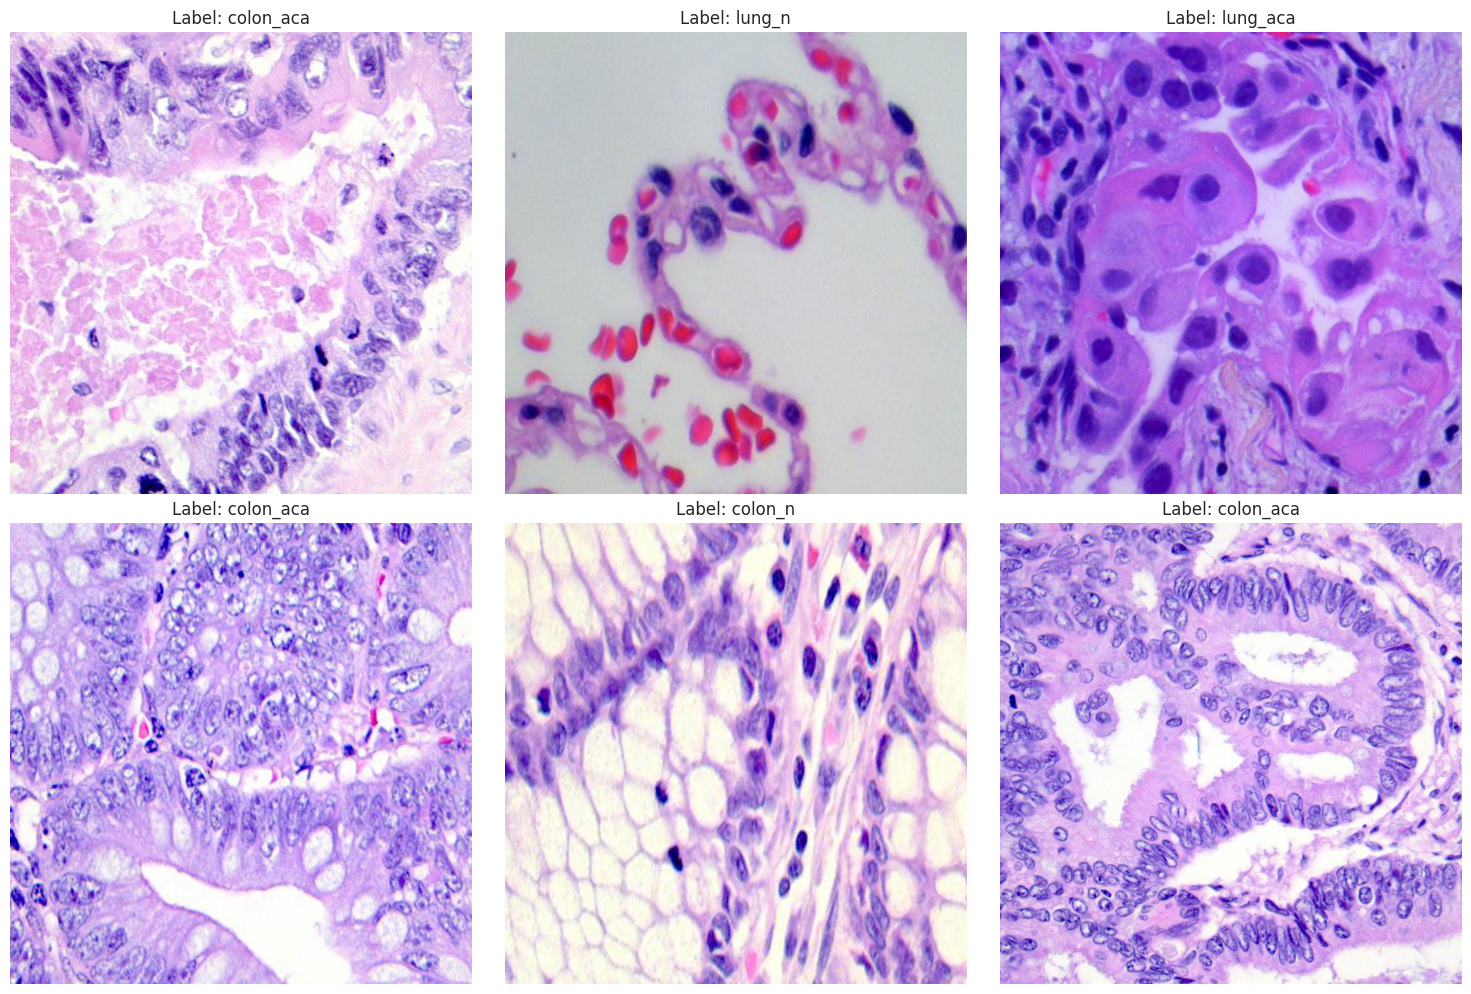

In [11]:
import random

# Function to plot images with their labels
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']
        
        # Read and plot the image
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(train_df)

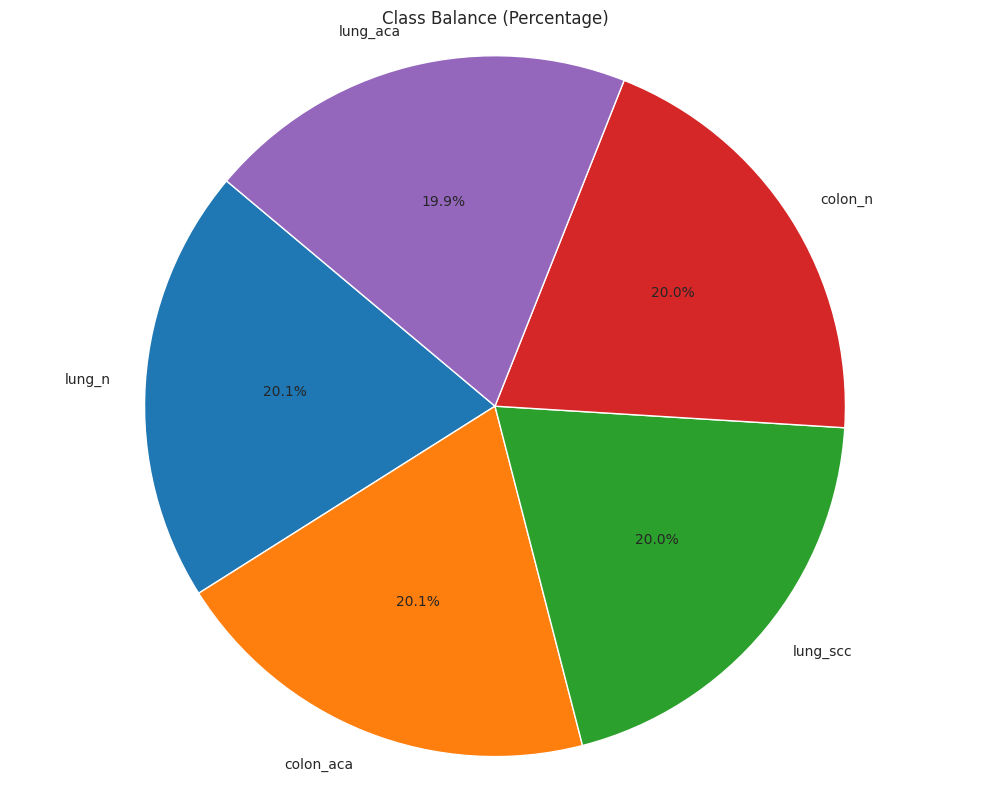

In [12]:
# Calculate class counts
class_counts = train_df['Labels'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Calculate the total number of images in train_df
total_images = len(train_df)

# Calculate the percentage for each class based on the total number of images
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

# Sort the dataframe by count
class_counts = class_counts.sort_values(by='Count', ascending=False)

# Create the pie chart using matplotlib
plt.figure(figsize=(10, 8))
plt.pie(class_counts['Percentage'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Class Balance (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [13]:
base_model = tf.keras.applications.xception.Xception(weights= 'imagenet' ,include_top = False , input_shape = (150,150,3) ,
                                                     pooling = 'max' )

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,activation = 'relu'),
    Dropout(.5),
    Dense(5 , activation= 'softmax' )
])
model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])
history = model.fit(
    x= train_generator ,
    validation_data= valid_generator ,
    epochs= 5 , verbose = 1 ,
    validation_steps= None, shuffle= False
   )

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5


I0000 00:00:1710481910.933209     251 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710481911.006028     251 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.9115 - loss: 0.2951

W0000 00:00:1710482250.418569     252 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


400/400 ━━━━━━━━━━━━━━━━━━━━ 436s 917ms/step - accuracy: 0.9116 - loss: 0.2947 - val_accuracy: 0.9904 - val_loss: 0.0301
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 177s 441ms/step - accuracy: 0.9852 - loss: 0.0456 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 175s 437ms/step - accuracy: 0.9908 - loss: 0.0278 - val_accuracy: 0.9956 - val_loss: 0.0106
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 176s 438ms/step - accuracy: 0.9925 - loss: 0.0264 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 176s 440ms/step - accuracy: 0.9931 - loss: 0.0221 - val_accuracy: 0.9992 - val_loss: 0.0023


In [14]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 578ms/step - accuracy: 1.0000 - loss: 3.4872e-04
Test Accuracy: 0.9995999932289124


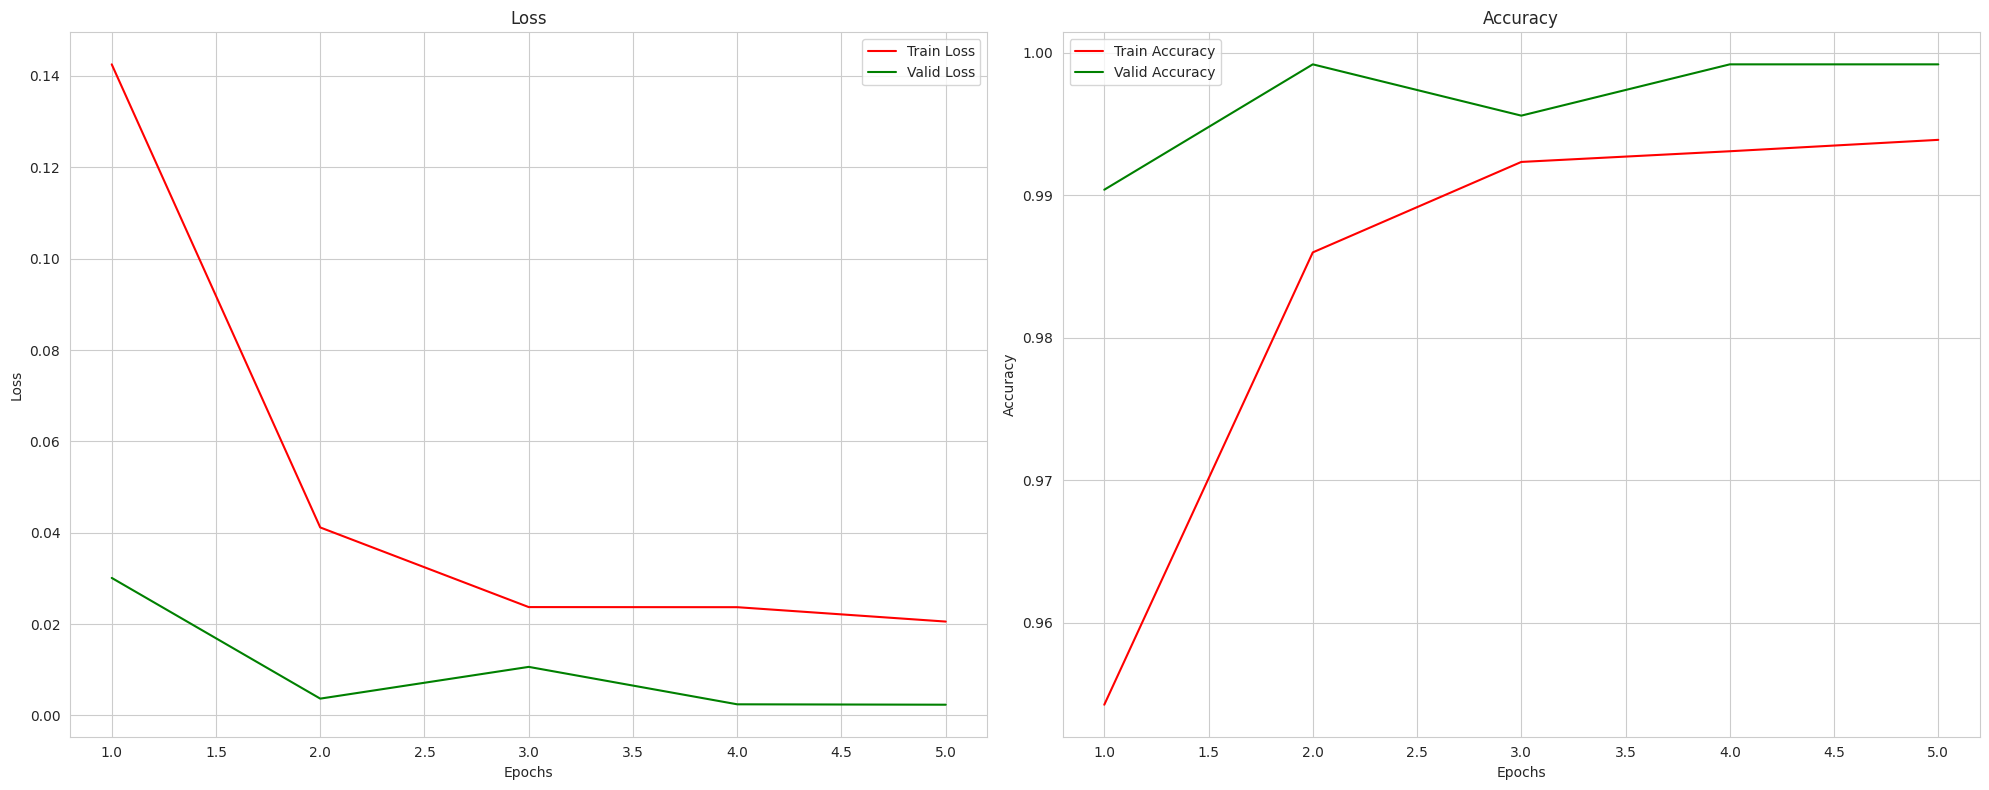

In [15]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()